# Exploratory Data Analysis

In this EDA code, we mainly perform 3 analysis:
1. Time series analysis on attributes (relationship between timestamp and attributes)
2. Relationships between meter_reading and attributes
3. Distributions of attributes on train and test data

Based on the following 'technologies' to perform EDA process:
1. Spark SQL: operating Spark DataFrame
2. Spark DataFrame/RDD: data structure
3. Pandas DataFrame: data sturcture
4. Matplotlib: for visualization
5. Seaborn: for visualization
6. Plotly: for visualization

Now the EDA process in processed attribute by attribute:

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

In [0]:
from pyspark.sql.functions import *
#from pyspark import SparkSession
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql.functions import date_format
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

import plotly
import plotly.express as px

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns   # 

## Data Loader

In [0]:
# Data Loader: in response for loading data (weather_train, weather_test, building_metadata) from mongodb cluster: YanzheYUAN:YanzheYUAN:Cluster0
def data_loader(username='YanzheYUAN', password='YanzheYUAN', cluster_name='cluster0', database_name='ashrae_db', collection_name='building_metadata',app_name='Databricks Shell'):
  my_spark = SparkSession \
             .builder \
             .appName("Databricks Shell") \
             .getOrCreate()
  db = my_spark.read.format("com.mongodb.spark.sql.DefaultSource") \
                    .option("uri", 'mongodb+srv://'+username+':'+password+'@'+cluster_name+'.3khuz.mongodb.net/'+database_name+'.'+collection_name+'?retryWrites=true&w=majority') \
                    .load()
  return db.drop('_id')


In [0]:
import pyspark
from pyspark.sql import SparkSession
weather_train_df = data_loader(database_name='ashrae_db',collection_name='weather_train')
weather_test_df = data_loader(database_name='ashrae_db',collection_name='weather_test')
building_df = data_loader(database_name='ashrae_db',collection_name='building_metadata')

In [0]:
building_df.show()

+-----------+-----------+--------------------+-------+-----------+----------+
building_id|floor_count| primary_use|site_id|square_feet|year_built|
+-----------+-----------+--------------------+-------+-----------+----------+
 0| null| Education| 0| 7432| 2008.0|
 1| null| Education| 0| 2720| 2004.0|
 2| null| Education| 0| 5376| 1991.0|
 3| null| Education| 0| 23685| 2002.0|
 4| null| Education| 0| 116607| 1975.0|
 5| null| Education| 0| 8000| 2000.0|
 6| null| Lodging/residential| 0| 27926| 1981.0|
 7| null| Education| 0| 121074| 1989.0|
 8| null| Education| 0| 60809| 2003.0|
 9| null| Office| 0| 27000| 2010.0|
 10| null|Entertainment/pub...| 0| 370773| 1991.0|
 11| null| Education| 0| 49073| 1968.0|
 12| null| Lodging/residential| 0| 37100| 1999.0|
 13| null| Education| 0| 99380| 2000.0|
 14| null| Education| 0| 86250| 2013.0|
 15| null| Office| 0| 83957| 1974.0|
 16| null| Education| 0| 54644| 1996.0|
 17| null| Office| 0| 15250| 1980.0|
 18| null| Education| 0| 111891| 1996.0|
 19| null| Office| 0| 18717| 2004.0|
+-----------+-----------+--------------------+-------+-----------+----------+
only showing top 20 rows

In [0]:
weather_test_df.show()

+---------------+--------------+---------------+-----------------+------------------+-------+-------------------+--------------+----------+
air_temperature|cloud_coverage|dew_temperature|precip_depth_1_hr|sea_level_pressure|site_id| timestamp|wind_direction|wind_speed|
+---------------+--------------+---------------+-----------------+------------------+-------+-------------------+--------------+----------+
 17.8| 4.0| 11.7| null| 1021.4| 0|2017-01-01 00:00:00| 100.0| 3.6|
 17.8| 2.0| 12.8| 0.0| 1022.0| 0|2017-01-01 01:00:00| 130.0| 3.1|
 16.1| 0.0| 12.8| 0.0| 1021.9| 0|2017-01-01 02:00:00| 140.0| 3.1|
 17.2| 0.0| 13.3| 0.0| 1022.2| 0|2017-01-01 03:00:00| 140.0| 3.1|
 16.7| 2.0| 13.3| 0.0| 1022.3| 0|2017-01-01 04:00:00| 130.0| 2.6|
 15.6| 2.0| 12.8| 0.0| 1022.1| 0|2017-01-01 05:00:00| 130.0| 2.1|
 15.0| 0.0| 12.8| 0.0| 1021.7| 0|2017-01-01 06:00:00| 150.0| 1.5|
 15.0| 2.0| 13.3| 0.0| 1021.6| 0|2017-01-01 07:00:00| 0.0| 0.0|
 13.3| 0.0| 12.2| 0.0| 1021.4| 0|2017-01-01 08:00:00| 0.0| 0.0|
 12.2| 4.0| 11.7| 0.0| 1021.4| 0|2017-01-01 09:00:00| 0.0| 0.0|
 13.9| 2.0| 12.8| 0.0| 1021.0| 0|2017-01-01 10:00:00| 80.0| 1.5|
 13.9| 0.0| 12.8| 0.0| 1021.0| 0|2017-01-01 11:00:00| 0.0| 0.0|
 12.2| 2.0| 11.1| 0.0| 1021.6| 0|2017-01-01 12:00:00| 110.0| 1.5|
 13.3| 2.0| 12.2| 0.0| 1021.9| 0|2017-01-01 13:00:00| 150.0| 3.1|
 17.8| 4.0| 15.0| 0.0| 1022.5| 0|2017-01-01 14:00:00| 160.0| 2.6|
 22.8| 4.0| 15.6| 0.0| 1023.0| 0|2017-01-01 15:00:00| 150.0| 4.1|
 23.9| null| 16.1| 0.0| 1023.2| 0|2017-01-01 16:00:00| 150.0| 5.1|
 25.6| null| 16.7| 0.0| 1022.6| 0|2017-01-01 17:00:00| 170.0| 4.6|
 25.6| 6.0| 16.1| 0.0| 1021.6| 0|2017-01-01 18:00:00| 150.0| 5.1|
 26.7| 4.0| 15.6| 0.0| 1020.5| 0|2017-01-01 19:00:00| 160.0| 4.6|
+---------------+--------------+---------------+-----------------+------------------+-------+-------------------+--------------+----------+
only showing top 20 rows

In [0]:
weather_train_df.show()

+---------------+--------------+---------------+-----------------+------------------+-------+-------------------+--------------+----------+
air_temperature|cloud_coverage|dew_temperature|precip_depth_1_hr|sea_level_pressure|site_id| timestamp|wind_direction|wind_speed|
+---------------+--------------+---------------+-----------------+------------------+-------+-------------------+--------------+----------+
 25.0| 6.0| 20.0| null| 1019.7| 0|2016-01-01 00:00:00| 0.0| 0.0|
 24.4| null| 21.1| -1.0| 1020.2| 0|2016-01-01 01:00:00| 70.0| 1.5|
 22.8| 2.0| 21.1| 0.0| 1020.2| 0|2016-01-01 02:00:00| 0.0| 0.0|
 21.1| 2.0| 20.6| 0.0| 1020.1| 0|2016-01-01 03:00:00| 0.0| 0.0|
 20.0| 2.0| 20.0| -1.0| 1020.0| 0|2016-01-01 04:00:00| 250.0| 2.6|
 19.4| null| 19.4| 0.0| null| 0|2016-01-01 05:00:00| 0.0| 0.0|
 21.1| 6.0| 21.1| -1.0| 1019.4| 0|2016-01-01 06:00:00| 0.0| 0.0|
 21.1| null| 21.1| 0.0| 1018.8| 0|2016-01-01 07:00:00| 210.0| 1.5|
 20.6| null| 20.0| 0.0| 1018.1| 0|2016-01-01 08:00:00| 0.0| 0.0|
 21.1| null| 20.6| 0.0| 1019.0| 0|2016-01-01 09:00:00| 290.0| 1.5|
 21.1| null| 20.6| -1.0| 1018.4| 0|2016-01-01 10:00:00| 0.0| 0.0|
 20.6| null| 20.0| 0.0| 1018.9| 0|2016-01-01 11:00:00| 0.0| 0.0|
 18.9| 6.0| 18.9| 0.0| 1019.2| 0|2016-01-01 12:00:00| 210.0| 1.5|
 20.0| null| 20.0| 0.0| 1019.6| 0|2016-01-01 13:00:00| 0.0| 0.0|
 21.7| null| 21.1| 0.0| 1020.1| 0|2016-01-01 14:00:00| 0.0| 0.0|
 23.9| null| 21.1| 0.0| 1020.3| 0|2016-01-01 15:00:00| 210.0| 3.1|
 26.1| null| 20.0| 0.0| 1020.2| 0|2016-01-01 16:00:00| 210.0| 4.1|
 26.7| null| 20.6| 0.0| 1019.5| 0|2016-01-01 17:00:00| 230.0| 3.6|
 27.8| 6.0| 20.0| 0.0| 1018.2| 0|2016-01-01 18:00:00| 200.0| 5.1|
 28.3| null| 19.4| 0.0| 1017.2| 0|2016-01-01 19:00:00| 180.0| 5.1|
+---------------+--------------+---------------+-----------------+------------------+-------+-------------------+--------------+----------+
only showing top 20 rows

In [0]:
# Due to large storage needed, we upload train and test data into Azure Databricks DBFS rather than MongoDB

# Load data from Databricks DBFS
train_df = spark.read.csv('/FileStore/tables/train.csv', header="true", inferSchema="true")
test_df = spark.read.csv('/FileStore/tables/test.csv', header="true", inferSchema="true")

In [0]:
test_df.show()

+------+-----------+-----+-------------------+
row_id|building_id|meter| timestamp|
+------+-----------+-----+-------------------+
 0| 0| 0|2017-01-01 00:00:00|
 1| 1| 0|2017-01-01 00:00:00|
 2| 2| 0|2017-01-01 00:00:00|
 3| 3| 0|2017-01-01 00:00:00|
 4| 4| 0|2017-01-01 00:00:00|
 5| 5| 0|2017-01-01 00:00:00|
 6| 6| 0|2017-01-01 00:00:00|
 7| 7| 0|2017-01-01 00:00:00|
 8| 7| 1|2017-01-01 00:00:00|
 9| 8| 0|2017-01-01 00:00:00|
 10| 9| 0|2017-01-01 00:00:00|
 11| 9| 1|2017-01-01 00:00:00|
 12| 10| 0|2017-01-01 00:00:00|
 13| 11| 0|2017-01-01 00:00:00|
 14| 12| 0|2017-01-01 00:00:00|
 15| 13| 0|2017-01-01 00:00:00|
 16| 13| 1|2017-01-01 00:00:00|
 17| 14| 0|2017-01-01 00:00:00|
 18| 14| 1|2017-01-01 00:00:00|
 19| 15| 0|2017-01-01 00:00:00|
+------+-----------+-----+-------------------+
only showing top 20 rows

In [0]:
train_df.show()

+-----------+-----+-------------------+-------------+
building_id|meter| timestamp|meter_reading|
+-----------+-----+-------------------+-------------+
 0| 0|2016-01-01 00:00:00| 0.0|
 1| 0|2016-01-01 00:00:00| 0.0|
 2| 0|2016-01-01 00:00:00| 0.0|
 3| 0|2016-01-01 00:00:00| 0.0|
 4| 0|2016-01-01 00:00:00| 0.0|
 5| 0|2016-01-01 00:00:00| 0.0|
 6| 0|2016-01-01 00:00:00| 0.0|
 7| 0|2016-01-01 00:00:00| 0.0|
 8| 0|2016-01-01 00:00:00| 0.0|
 9| 0|2016-01-01 00:00:00| 0.0|
 10| 0|2016-01-01 00:00:00| 0.0|
 11| 0|2016-01-01 00:00:00| 0.0|
 12| 0|2016-01-01 00:00:00| 0.0|
 13| 0|2016-01-01 00:00:00| 0.0|
 14| 0|2016-01-01 00:00:00| 0.0|
 15| 0|2016-01-01 00:00:00| 0.0|
 16| 0|2016-01-01 00:00:00| 0.0|
 17| 0|2016-01-01 00:00:00| 0.0|
 18| 0|2016-01-01 00:00:00| 0.0|
 19| 0|2016-01-01 00:00:00| 0.0|
+-----------+-----+-------------------+-------------+
only showing top 20 rows

## EDA for train_df and test_df

In [0]:
# EDA for train_df and test_df
# Based on Spark sql and Spark DataFrame and pandas, We used matplotplib and plotly packages to perform EDA visualization.
# Author: YUAN Yan Zhe

from pyspark.sql.types import FloatType
from pyspark.sql.functions import date_format
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType

In [0]:
# Time series analysis on meter_reading

train_ts=train_df.select('*').groupby(['timestamp']).sum('meter_reading').withColumnRenamed('sum(meter_reading)', 'total_meter_reading').orderBy('timestamp', ascending=True)
print(train_ts.count())
train_ts.show()


8784
+-------------------+-------------------+
 timestamp|total_meter_reading|
+-------------------+-------------------+
2016-01-01 00:00:00| 4211283.5948|
2016-01-01 01:00:00| 4251482.203599998|
2016-01-01 02:00:00| 1259595.3711000003|
2016-01-01 03:00:00| 1009027.1127999999|
2016-01-01 04:00:00| 1170655.4664|
2016-01-01 05:00:00| 2928957.337000003|
2016-01-01 06:00:00| 1134042.783099999|
2016-01-01 07:00:00| 1137632.664700002|
2016-01-01 08:00:00| 1385341.9682000005|
2016-01-01 09:00:00| 4684000.359299993|
2016-01-01 10:00:00| 4441235.823000007|
2016-01-01 11:00:00| 3776624.0941999992|
2016-01-01 12:00:00| 3661970.705199999|
2016-01-01 13:00:00| 3611177.5591999986|
2016-01-01 14:00:00| 3673415.040200004|
2016-01-01 15:00:00| 3786842.958999998|
2016-01-01 16:00:00| 4041471.6193000004|
2016-01-01 17:00:00| 3414924.992900001|
2016-01-01 18:00:00| 3550473.850000003|
2016-01-01 19:00:00| 3360025.109699997|
+-------------------+-------------------+
only showing top 20 rows

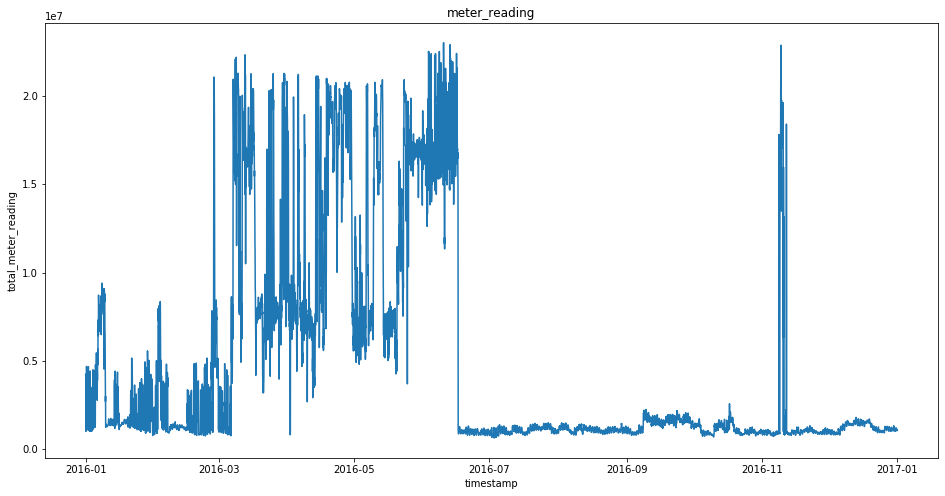

In [0]:
# Visualization

train_ts_pd = train_ts.toPandas()
train_ts_pd["timestamp"] = pd.to_datetime(train_ts_pd["timestamp"], format='%Y-%m-%d %H:%M:%S')

x = train_ts_pd.timestamp
y = train_ts_pd.total_meter_reading
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('total_meter_reading')
plt.plot(x,y)


In [0]:
# The plotly version
import plotly.express as px

fig_total = px.line(train_ts_pd, x='timestamp', y='total_meter_reading', render_mode='svg')
fig_total.update_layout(title='meter_reading time line graph')
fig_total.show()

In [0]:
# Time series analysis on meter_reading of every meter type

# trun timestamp to date
train_dt = train_df.select('*',date_format('timestamp', 'yyy-MM-dd').alias('date')).drop('timestamp')
train_dt.show()

# An example of date_format()
#from pyspark.sql.functions import date_format
#temp = spark.createDataFrame([('2016-01-01 12:10:09',)], ['a'])
#temp.select(date_format('a', 'HH/mm/ss/MM/dd/yyy').alias('date')).show()

+-----------+-----+-------------+----------+
building_id|meter|meter_reading| date|
+-----------+-----+-------------+----------+
 0| 0| 0.0|2016-01-01|
 1| 0| 0.0|2016-01-01|
 2| 0| 0.0|2016-01-01|
 3| 0| 0.0|2016-01-01|
 4| 0| 0.0|2016-01-01|
 5| 0| 0.0|2016-01-01|
 6| 0| 0.0|2016-01-01|
 7| 0| 0.0|2016-01-01|
 8| 0| 0.0|2016-01-01|
 9| 0| 0.0|2016-01-01|
 10| 0| 0.0|2016-01-01|
 11| 0| 0.0|2016-01-01|
 12| 0| 0.0|2016-01-01|
 13| 0| 0.0|2016-01-01|
 14| 0| 0.0|2016-01-01|
 15| 0| 0.0|2016-01-01|
 16| 0| 0.0|2016-01-01|
 17| 0| 0.0|2016-01-01|
 18| 0| 0.0|2016-01-01|
 19| 0| 0.0|2016-01-01|
+-----------+-----+-------------+----------+
only showing top 20 rows

In [0]:
# Turn numerical meter value into string type and sum the meter_reading of every date
from pyspark.sql.types import StringType

match_dict = {'0':'electricity', '1':'chilledwater', '2':'steam', '3':'hotwater'}
train_dt_str = train_dt.select('*',train_dt.meter.cast(StringType()).alias('meter_string'))\
                       .na.replace(match_dict,'meter_string')\
                       .drop('meter')
# train_dt_str.select('*').where('meter=3').show()

train_dt_result = train_dt_str.select('*') \
                              .groupBy(['date','meter_string'])\
                              .sum('meter_reading').withColumnRenamed('sum(meter_reading)','categorical_sum_meter_reading')\
                              .orderBy('date',ascending=True)
                              #.max('meter_reading').withColumnRenamed('max(meter_reading)','max_meter_reading')\
                              #.min('meter_reading').withColumnRenamed('min(meter_reading)','min_meter_reading')\
                              
train_dt_result.select('*').show()

/databricks/spark/python/pyspark/sql/dataframe.py:1912: UserWarning:

to_replace is a dict and value is not None. value will be ignored.

+----------+------------+-----------------------------+
 date|meter_string|categorical_sum_meter_reading|
+----------+------------+-----------------------------+
2016-01-01| steam| 6.873200526159999E7|
2016-01-01| hotwater| 1609989.3408000013|
2016-01-01|chilledwater| 1412168.815300002|
2016-01-01| electricity| 4219647.315199988|
2016-01-02| electricity| 4288951.165099983|
2016-01-02| steam| 3.661504778289999E7|
2016-01-02|chilledwater| 1439739.8251|
2016-01-02| hotwater| 2015528.7509999971|
2016-01-03| electricity| 4247301.164000006|
2016-01-03| hotwater| 1843819.8814000057|
2016-01-03| steam| 3.565663171619995E7|
2016-01-03|chilledwater| 1510352.091199998|
2016-01-04| electricity| 5005502.71159998|
2016-01-04| steam| 4.8600057529899776E7|
2016-01-04|chilledwater| 1516235.709699993|
2016-01-04| hotwater| 2695869.753000004|
2016-01-05| steam| 7.854873046719986E7|
2016-01-05| hotwater| 2483300.945000012|
2016-01-05| electricity| 5095315.305600022|
2016-01-05|chilledwater| 1472645.7947999993|
+----------+------------+-----------------------------+
only showing top 20 rows

In [0]:
# Visualization

import plotly.express as px

fig_total = px.line(train_dt_result.toPandas(), x='date', y='categorical_sum_meter_reading', color='meter_string', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy category')
fig_total.show()

## EDA for weather_train_df and weather_test_df

In [1]:
# EDA for weather_train_df and weather_test_df
# Based on Spark sql and Spark DataFrame and pandas, We used seaborn and matplotplib packages to perform visualization.
# Author: YUAN Yan Zhe

# Distribution of weather_train and weather_test data on specific attributes
import seaborn as sns
def plot_dist_attr(dataframe_1, dataframe_2, attribute):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(dataframe_1.select(attribute).dropna().toPandas(), color='green', ax=ax).set_title(attribute, fontsize=16)
    sns.distplot(dataframe_2.select(attribute).dropna().toPandas(), color='purple', ax=ax).set_title(attribute, fontsize=16)
    plt.xlabel(attribute, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

# Draw relationship line graph on attributes from weather_train_df with meter_reading from train_df
def plot_weather_train_data(attribute):
  '''plot bar graph on attributes(for the given column name) in weather_train_df with meter_readings in train_df'''
  # spark.DataFrame.sql:
  train_weather_df = train_df.join(building_df,'building_id','left')\
                              .join(weather_train_df,['site_id','timestamp'],'left')\
                              .groupBy(attribute).mean('meter_reading')\
                              .withColumnRenamed('avg(meter_reading)','mean_meter_reading')\
                              .orderBy(attribute,ascending=True)
  # start ploting:
  fig, axes = plt.subplots(1,1,figsize=(14, 6))
  pd.Series(index=train_weather_df.toPandas()[attribute].values, data=train_weather_df.toPandas().mean_meter_reading.values).plot().set_ylabel('Mean meter reading')
  axes.set_title('Mean meter reading by '+attribute+' of the building', fontsize=16);

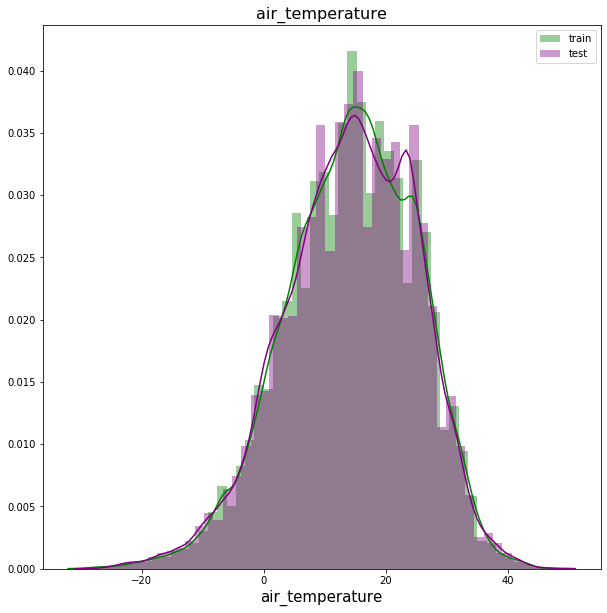

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'air_temperature')

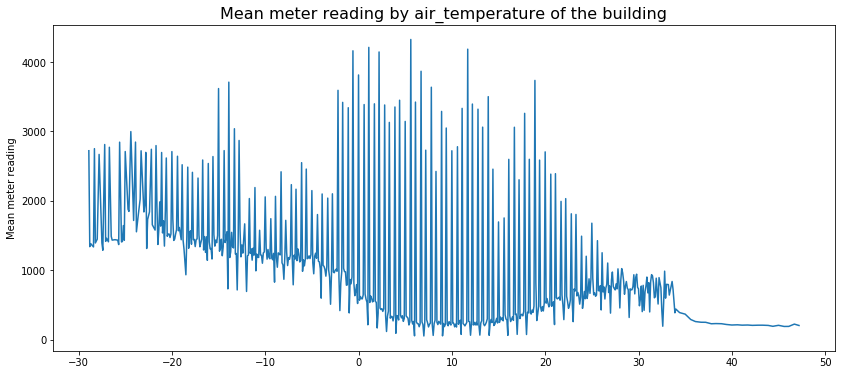

In [0]:
plot_weather_train_data('air_temperature')
#train_weather_df = train_df.join(building_df,'building_id','left')\
#                           .join(weather_train_df,['site_id','timestamp'],'left')\
#                           .groupBy('air_temperature').mean('meter_reading')\
#                           .withColumnRenamed('avg(meter_reading)','mean_meter_reading')\
#                           .orderBy('air_temperature',ascending=True)\
# start ploting:
#fig, axes = plt.subplots(1,1,figsize=(14, 6))
#pd.Series(index=train_weather_df.toPandas().air_temperature.values, data=train_weather_df.toPandas().air_temperature.values).plot().set_ylabel('Mean meter reading')
#axes.set_title('Mean meter reading by air_temperature of the building', fontsize=16);

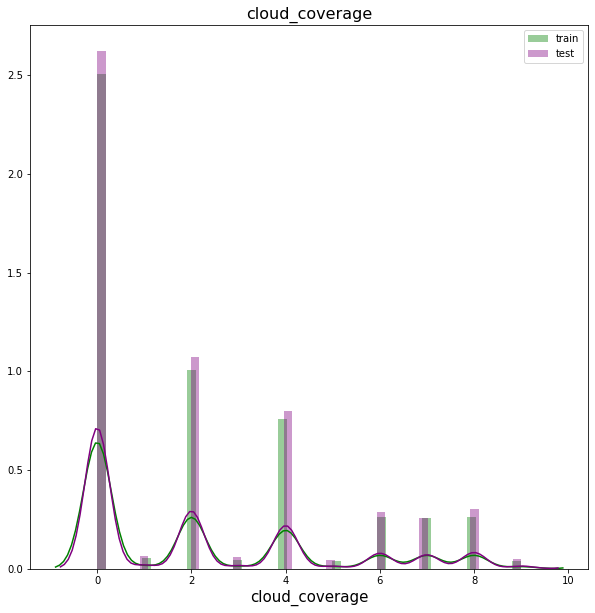

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'cloud_coverage')

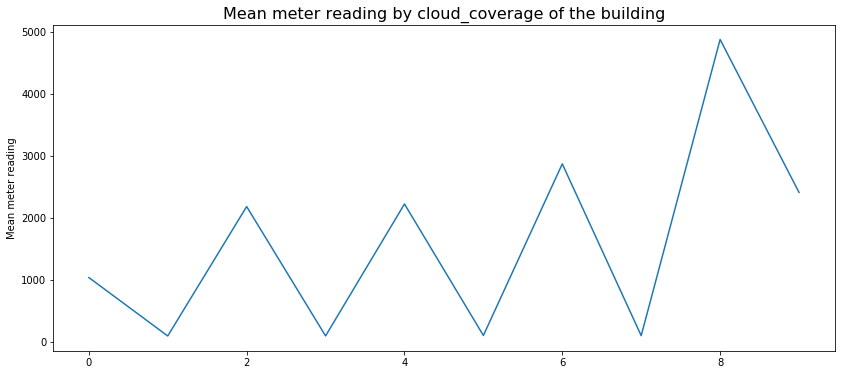

In [0]:
plot_weather_train_data('cloud_coverage')

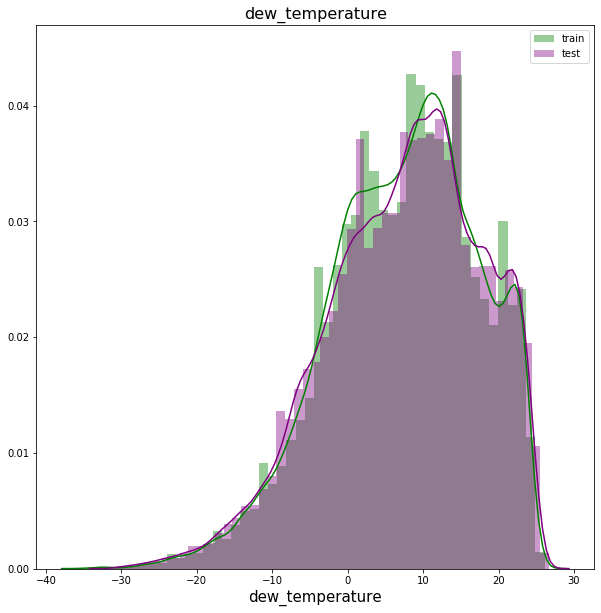

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'dew_temperature')

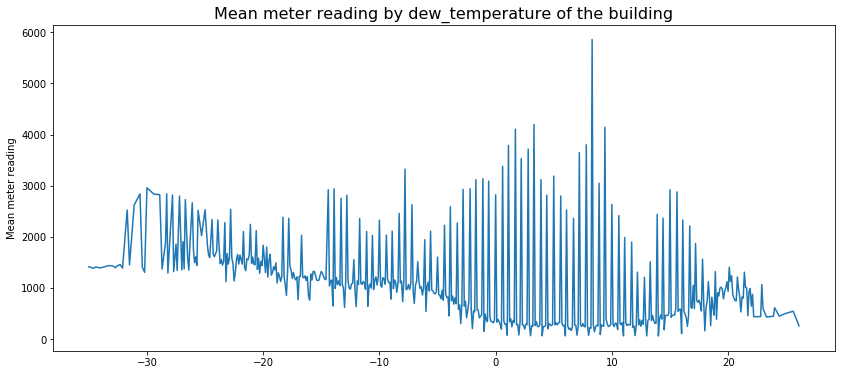

In [0]:
plot_weather_train_data('dew_temperature')

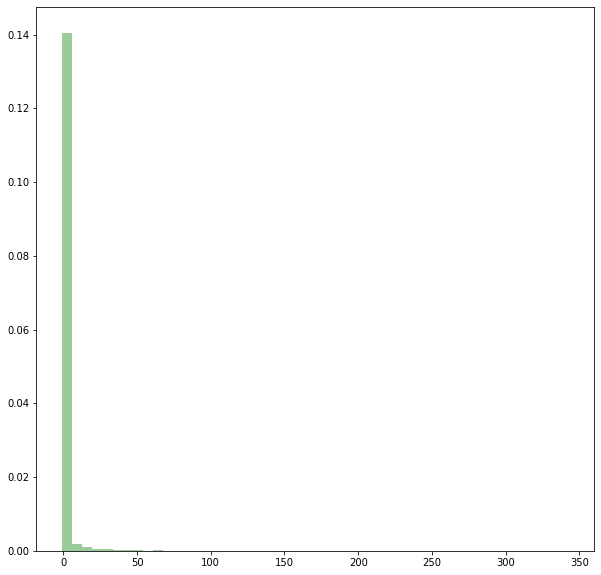

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'precip_depth_1_hr')

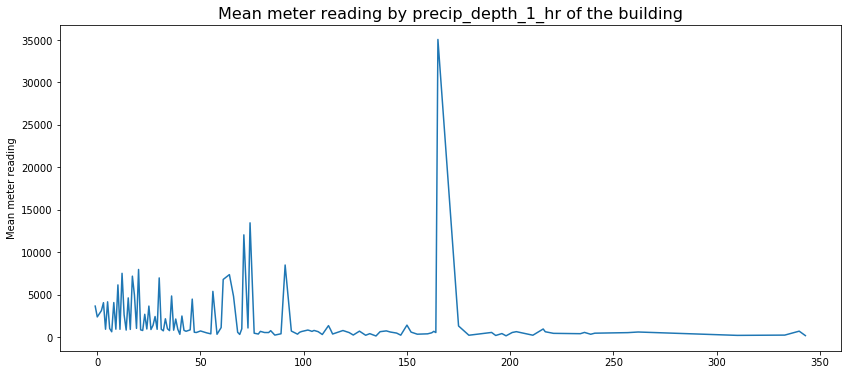

In [0]:
plot_weather_train_data('precip_depth_1_hr')

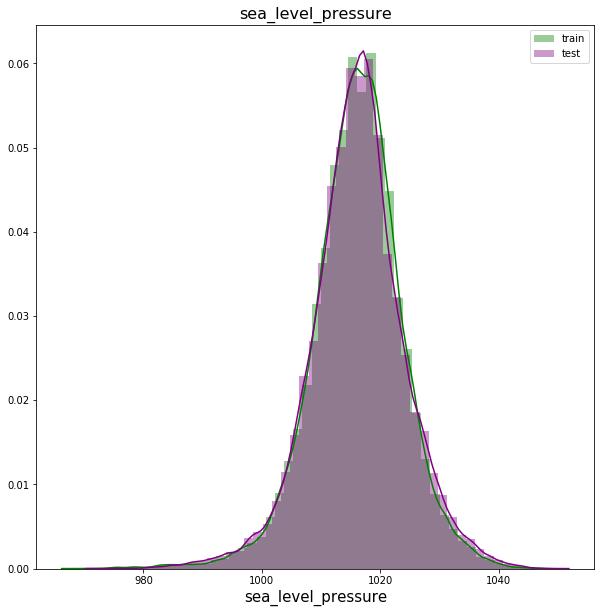

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'sea_level_pressure')

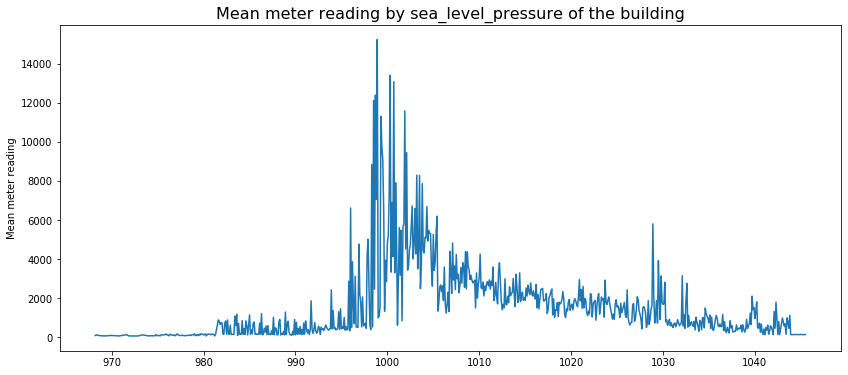

In [0]:
plot_weather_train_data('sea_level_pressure')

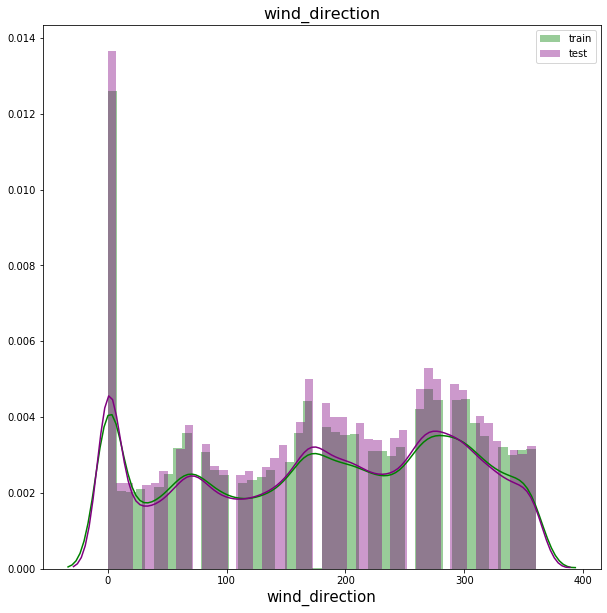

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'wind_direction')

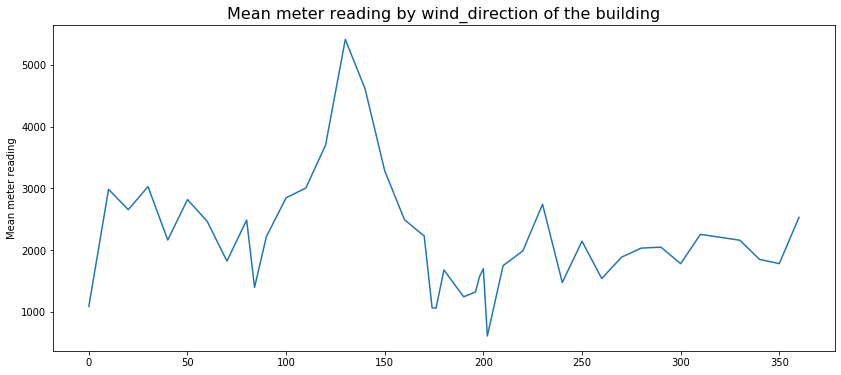

In [0]:
plot_weather_train_data('wind_direction')

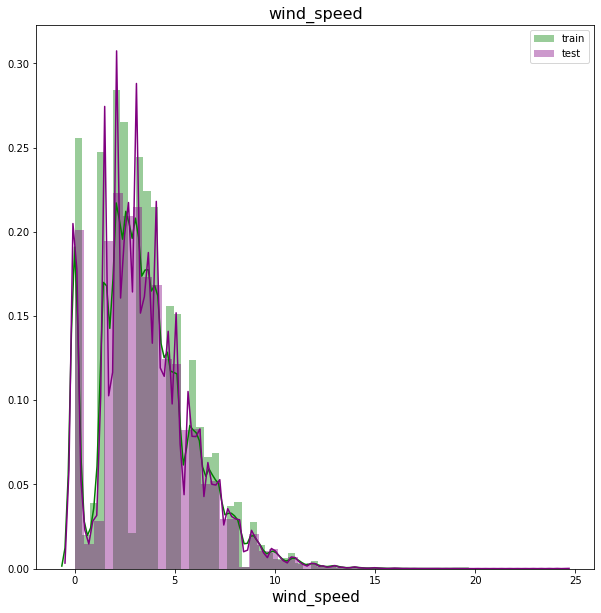

In [0]:
plot_dist_attr(weather_train_df, weather_test_df, 'wind_speed')

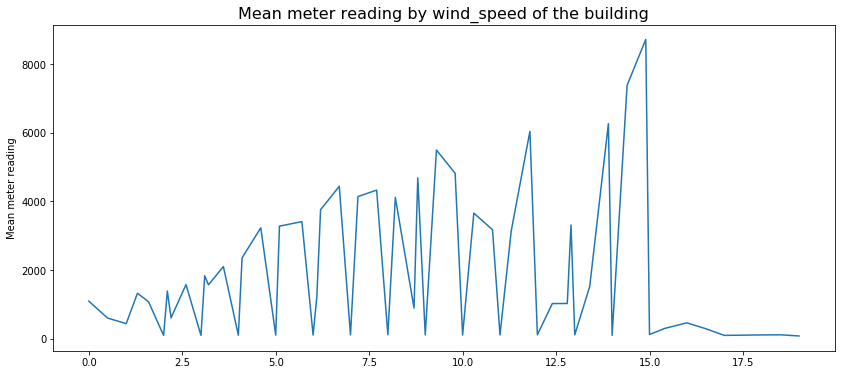

In [0]:
plot_weather_train_data('wind_speed')

## EDA for building_metadata

In [0]:
# EDA for building_metadata
# Based on Spark sql and Spark DataFrame and pandas, We used matplotplib packages to perform EDA visualization.
# Author: YUAN Yan Zhe, WEN Ze, SONG Di, LOU Yuqi

from pyspark.sql.types import FloatType
from pyspark.sql.functions import date_format
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType

In [0]:
# Relationship between floor_count and meter_reading

data_floor_count = train_df.join(building_df, 'building_id', 'left')\
               .groupBy('floor_count').mean('meter_reading')\
               .withColumnRenamed('avg(meter_reading)' ,'mean_meter_reading')\
               .orderBy('floor_count', ascending=True)\
               .fillna(0)
data_floor_count.show()


+-----------+------------------+
floor_count|mean_meter_reading|
+-----------+------------------+
 0.0|2506.1349642526543|
 1.0| 60.31496977361199|
 2.0|284.38470128789663|
 3.0| 264.8161105252521|
 4.0| 60.51624429672327|
 5.0|414.14624174965525|
 6.0| 285.20444670665|
 7.0|295.05170810210285|
 8.0|239.63613753665769|
 9.0|399.49712591533927|
 10.0|214.92215479931076|
 11.0|1368.6195881851472|
 12.0| 869.6102238794924|
 13.0| 1275.924261137305|
 14.0|232.88370237959705|
 16.0| 30.87821038251366|
 19.0| 809.1764985005512|
 21.0|1303.9997122575278|
 26.0|1389.2805071995756|
+-----------+------------------+

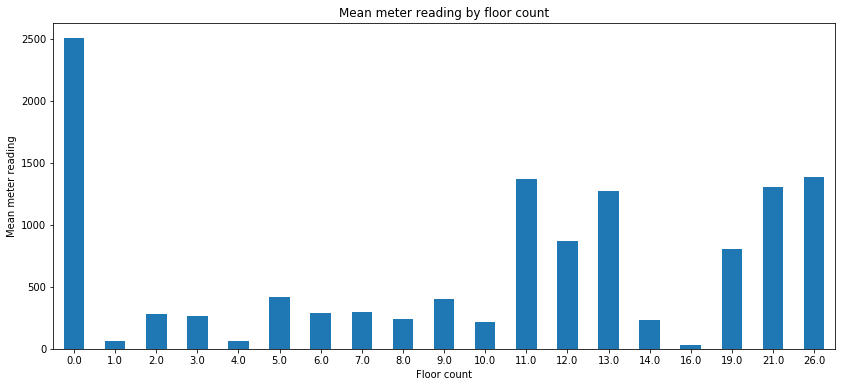

In [0]:
# Visualization

fig, axes = plt.subplots(1,1,figsize=(14, 6))
#Mean meter reading by floor count
pd.Series(index=data_floor_count.toPandas().floor_count.values,data=data_floor_count.toPandas().mean_meter_reading.values).plot(kind='bar', rot=0, ax=axes);
axes.set_xlabel('Floor count');
axes.set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by floor count');

In [0]:
# Relationship between primary_use and meter_reading
data_primary_use = train_df.join(building_df, 'building_id', 'left')\
               .groupBy('primary_use').mean('meter_reading')\
               .withColumnRenamed('avg(meter_reading)' ,'mean_meter_reading')\
               .orderBy('primary_use', ascending=True)\
               .fillna(0)
data_primary_use.show()

+--------------------+------------------+
 primary_use|mean_meter_reading|
+--------------------+------------------+
 Education| 4585.09184007385|
Entertainment/pub...|473.88069114839163|
Food sales and se...|304.90801788412773|
 Healthcare| 738.5975832450531|
 Lodging/residential| 279.7104388333785|
Manufacturing/ind...| 285.8970045699337|
 Office| 526.5044202435793|
 Other| 138.7037861577381|
 Parking| 169.3868006370597|
 Public services| 288.2378459941168|
 Religious worship| 5.375845904020289|
 Retail| 139.782388121468|
 Services| 4113.468284397888|
 Technology/science|138.20425784714072|
 Utility| 512.7368605679416|
 Warehouse/storage| 54.36231376172247|
+--------------------+------------------+

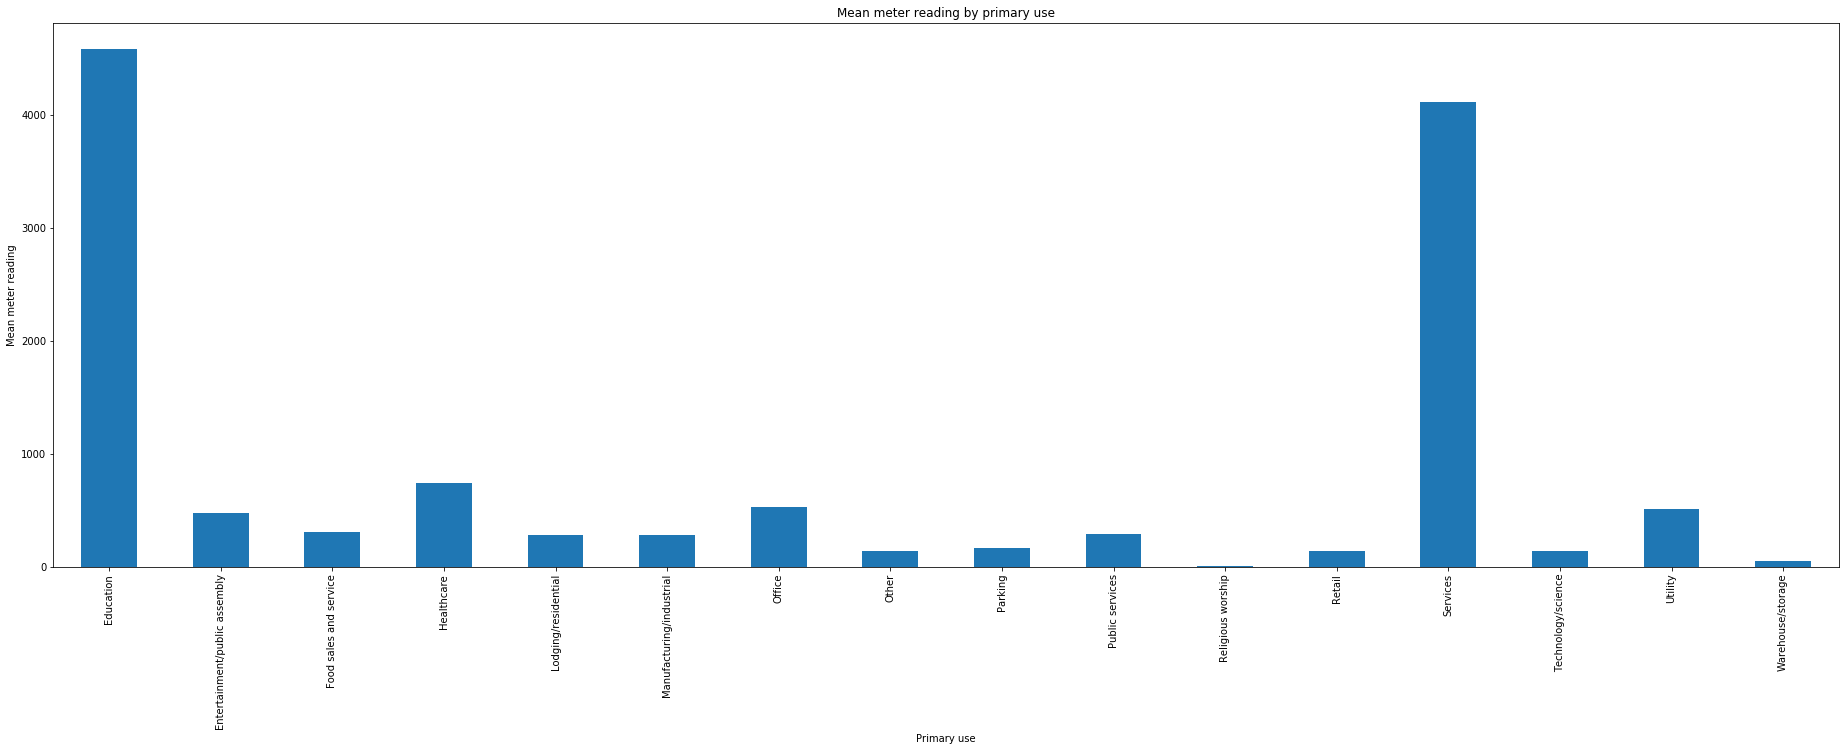

In [0]:
# Visualization

fig, axes = plt.subplots(1,1,figsize=(32, 10))
#Mean meter reading by primary use
pd.Series(index=data_primary_use.toPandas().primary_use.values, data=data_primary_use.toPandas().mean_meter_reading.values).plot(kind='bar', rot=90, ax=axes)
axes.set_xlabel('Primary use')
axes.set_ylabel('Mean meter reading')
axes.set_title('Mean meter reading by primary use')

In [0]:
train_df.show()

+-----------+-----+-------------------+-------------+
building_id|meter| timestamp|meter_reading|
+-----------+-----+-------------------+-------------+
 0| 0|2016-01-01 00:00:00| 0.0|
 1| 0|2016-01-01 00:00:00| 0.0|
 2| 0|2016-01-01 00:00:00| 0.0|
 3| 0|2016-01-01 00:00:00| 0.0|
 4| 0|2016-01-01 00:00:00| 0.0|
 5| 0|2016-01-01 00:00:00| 0.0|
 6| 0|2016-01-01 00:00:00| 0.0|
 7| 0|2016-01-01 00:00:00| 0.0|
 8| 0|2016-01-01 00:00:00| 0.0|
 9| 0|2016-01-01 00:00:00| 0.0|
 10| 0|2016-01-01 00:00:00| 0.0|
 11| 0|2016-01-01 00:00:00| 0.0|
 12| 0|2016-01-01 00:00:00| 0.0|
 13| 0|2016-01-01 00:00:00| 0.0|
 14| 0|2016-01-01 00:00:00| 0.0|
 15| 0|2016-01-01 00:00:00| 0.0|
 16| 0|2016-01-01 00:00:00| 0.0|
 17| 0|2016-01-01 00:00:00| 0.0|
 18| 0|2016-01-01 00:00:00| 0.0|
 19| 0|2016-01-01 00:00:00| 0.0|
+-----------+-----+-------------------+-------------+
only showing top 20 rows

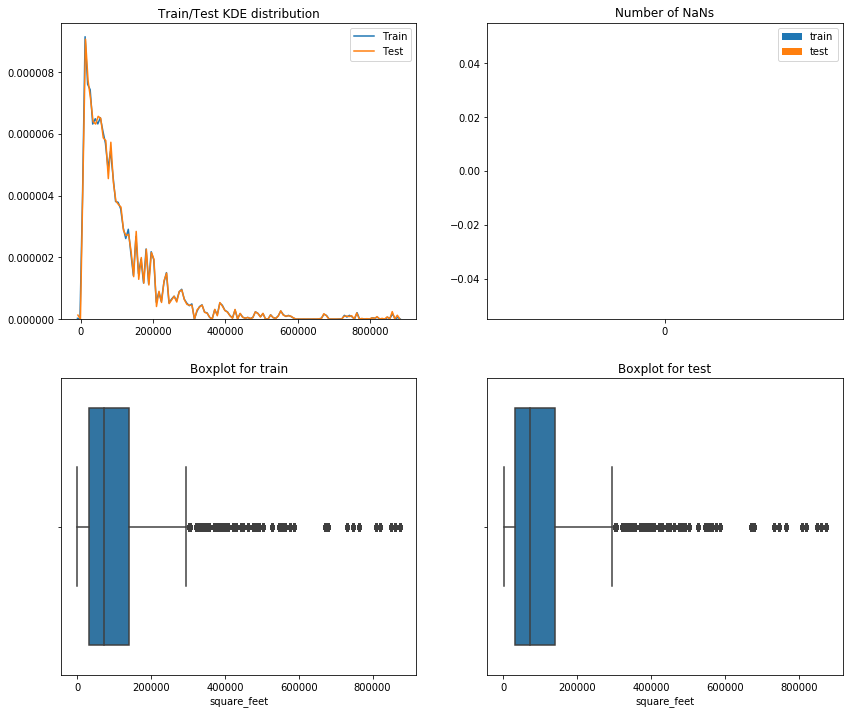

In [0]:
# Square feet analysis
# provided by SONG Di, using pandas

train = train_df.join(building_df,'building_id','left').toPandas()
test = test_df.join(building_df,'building_id','left').toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
#.kdeplot(data,data2=None,shade=False,vertical=False,kernel='gau',bw='scott',gridsize=100,cut=3,clip=None,legend=True,cumulative=False,shade_lowest=True,cbar=False, cbar_ax=None, cbar_kws=None, ax=None, *kwargs)
#KDE(kernel density estimate)图的数据源，子图位置，图像标记
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
#（横向）箱型图数据源，子图位置
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
#统计NaN并画柱图放在子图[0][1]
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

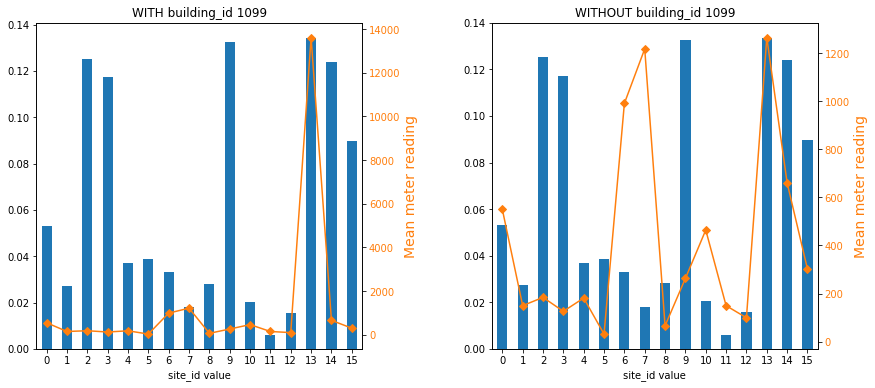

In [0]:
# Site_id and build_id with meter_reading
# provided by SONG Di

train = train_df.join(building_df,'building_id','left').toPandas()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# drow bar graph
train['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train[train['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
# shared x
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
# drow line graph
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train[train['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
# set labels
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
# adjust left-right space
plt.subplots_adjust(wspace=0.4)
# set titles seperately
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

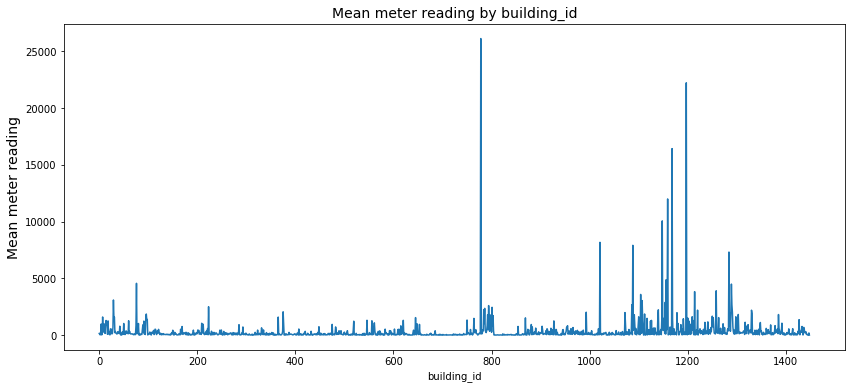

In [0]:
# building id with mean meter readng
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

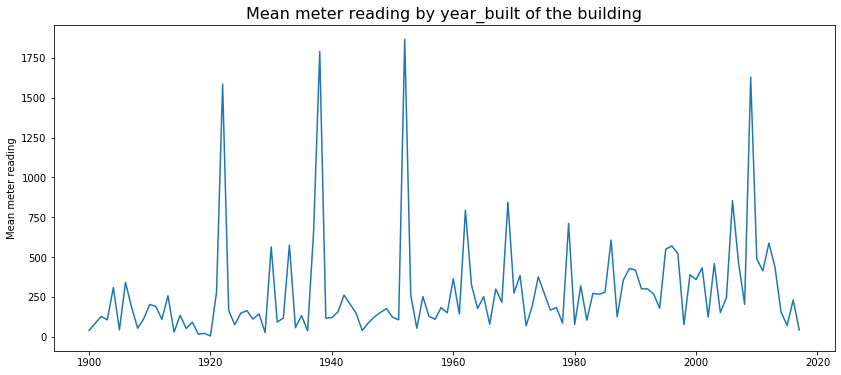

In [0]:
# Relationship between year_built and meter_reading

train_df_year_built = train_df.join(building_df,'building_id','left')\
                              .groupBy('year_built').mean('meter_reading')\
                              .withColumnRenamed('avg(meter_reading)','mean_meter_reading')\
                              .orderBy('year_built',ascending=True)

fig, axes = plt.subplots(1,1,figsize=(14, 6))
pd.Series(index=train_df_year_built.toPandas().year_built.values, data=train_df_year_built.toPandas().mean_meter_reading.values).plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

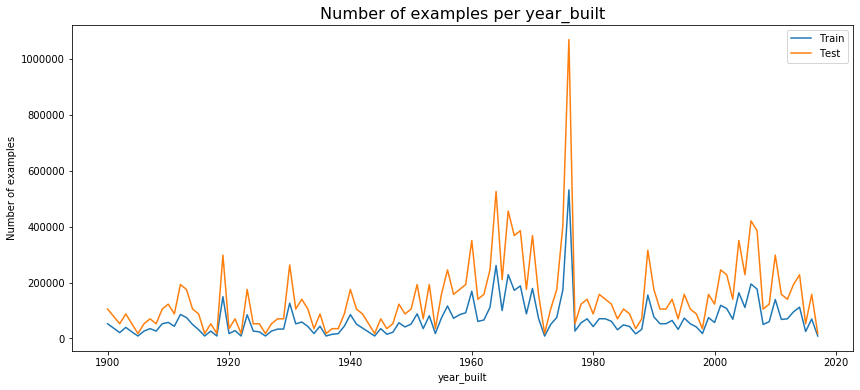

In [0]:
# Distributions of year_built on train and test data
# provided by SONG Di, using pandas

train = train_df.join(building_df,'building_id','left').toPandas()
test = test_df.join(building_df,'building_id','left').toPandas()

fig, axes = plt.subplots(1,1,figsize=(14, 6))
#Number of examples per year_buil
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('year_built');
test['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_ylabel('Number of examples');
axes.legend(['Train', 'Test']);
axes.set_title('Number of examples per year_built', fontsize=16);